In [1]:
from scipy.stats import norm
import numpy as np
import bisect as bisect
from scipy import interpolate
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from tqdm import tqdm
import matplotlib.pyplot as plt 
import pandas as pd
import time
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import tensorflow as tf
print('TF version: ',tf.__version__) # works with 2.4

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.keras import TqdmCallback

from tensorflow import keras
from tensorflow.keras import layers

import datetime             

import pathlib
import shutil

tf.keras.backend.set_floatx('float32') # default
real_type = tf.float32

%load_ext tensorboard

import shutil

TF version:  2.4.1


In [66]:
from timeit import default_timer as timer
from tqdm import tqdm_notebook

In [2]:
def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)

In [3]:
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5,
                 lower=0.35,
                 upper=1.65):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m,  anti=True, seed=None):
    
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])

        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    def trainingSetUniformS1(self, m, lower=0.35, upper=1.65, anti=True, seed=None):

        np.random.seed(seed)

        # 1 set of uniform samples in the one-dim parameter space for S1=S1(R1)
        S1 = np.random.uniform(lower,upper,m)
        
        # 2 sets of normal returns, only R2 required
        returns = np.random.normal(size=[m, 1])

        # SDE
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,0])
        # S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,0])
            S2a = S1 * R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])

    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas

In [5]:
class AutodiffLayer(tf.keras.layers.Layer):
    def __init__(self, fwd_model, **kwargs):
      super(AutodiffLayer, self).__init__(**kwargs)
      self.units = None
      self.fwd_model = fwd_model # weights of ref layer 'collected' by tensorflow
    
    def call(self, input):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(input)
            pred_value = self.fwd_model(input)
           
        # Get the gradients of the loss w.r.t to the pricing inputs
        gradient = tape.gradient(pred_value, input)

        return gradient
    
    def get_config(self):
        config = super(AutodiffLayer, self).get_config()
        config.update({"fwd_model": self.fwd_model})
        return config

class Autoencoder(tf.keras.layers.Layer):
    def __init__(self, input_dim, latent_dim, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.latent_dim = min(latent_dim, input_dim)   
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            # layers.Dense(20,  kernel_initializer='glorot_normal', activation = 'linear'),
            layers.Dense(latent_dim,  kernel_initializer='glorot_normal', activation = 'linear'),
        ])
        self.decoder = tf.keras.Sequential([
            # layers.Dense(20,  kernel_initializer='glorot_normal', activation = 'linear'),
            layers.Dense(input_dim,  kernel_initializer='glorot_normal', activation = 'linear'),
            # layers.Dense(1,  activation = 'softplus'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_config(self):
        config = super(Autoencoder, self).get_config()
        config.update({"latent_dim": self.latent_dim})
        return config

In [6]:
def get_model_autodiff(input_dim):

    # feedforward
    input_1 = layers.Input(shape=(input_dim,))
    x = layers.Dense(20, kernel_initializer='glorot_normal', activation='softplus', name='FWD_L1')(input_1)
    x = layers.Dense(20, kernel_initializer='glorot_normal', activation='softplus', name='FWD_L2')(x)
    x = layers.Dense(20, kernel_initializer='glorot_normal', activation='softplus', name='FWD_L3')(x)
    x = layers.Dense(20, kernel_initializer='glorot_normal', activation='softplus', name='FWD_L4')(x)
    y_pred = layers.Dense(1, kernel_initializer='glorot_normal', activation='linear', name='y_pred')(x)

    fwd_model = tf.keras.models.Model(inputs=input_1, outputs=y_pred)

    # autodiff

    autodiff_layer = AutodiffLayer(fwd_model, name='dydx_pred')
    dydx_pred = autodiff_layer(input_1)

    model = tf.keras.models.Model(inputs=input_1, outputs=[y_pred, dydx_pred], name='Autodiff_Autoencoder')
                                          

    return model

In [7]:
class WarmUpSchedule(tf.optimizers.schedules.LearningRateSchedule):
    def __init__(self, steps_per_epoch):
        super(WarmUpSchedule, self).__init__()
        self.ms = 100 * steps_per_epoch # original schedule calibrated to 100 epochs
        boundaries = (0.0, 0.2, 0.6, 0.9, 1.0)
        values = (1e-08, 0.1, 0.01, 1e-06, 1e-08)
        self.interp = tf.convert_to_tensor(
            [np.interp(step / self.ms, boundaries, values) for step in np.arange(0,self.ms)],
            dtype=tf.float32
            )

    @tf.function
    def __call__(self, step):
        if (tf.cast(step, tf.int32) >= self.ms):
            return 1e-08
        else:
            return tf.gather(self.interp, tf.cast(step, tf.int32))
lr_warmup = WarmUpSchedule(16)

lr_inv_time_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,
  decay_steps=16*100,
  decay_rate=50,
  staircase=False)

In [8]:
class NormalisationLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(NormalisationLayer, self).__init__(**kwargs)

        self.muX = 0
        self.muY = 0 
        self.stdX = 0
        self.stdY = 0

        self.n = 0

    def adapt(self, x_raw, y_raw, dydx_raw):
        # basic processing (step 1 in the note)
        
        x0 = x_raw
        y0 = y_raw
        x0Bar = dydx_raw
        
        self.n = x_raw.shape[1] 
        m = x_raw.shape[0] # size of training set

        # normalize inputs
        # compute
        self.muX = x0.mean(axis=0)
        self.stdX = x0.std(axis=0)
       
        # normalize inputs
        # compute
        self.muY = y0.mean(axis=0)
        self.stdY = y0.std(axis=0)
        

    def call(self, inputs):
        # layer called on x as inputs
        return (inputs - self.muX) /  self.stdX
    
    def yScaled(self, y):
        return (y - self.muY) / self.stdY

    def yScaledInverse(self, y):
        return (y * self.stdY ) + self.muY

    def dydxScaled(self, dydx):
        return dydx * (self.stdX / self.stdY)
    
    def dydxScaledInverse(self, dydx_scaled):
        return dydx_scaled * (self.stdY / self.stdX)
    
    def output_n(self):
        return self.n

    def get_config(self):
        config = super(NormalisationLayer, self).get_config()
        return config

In [9]:
def preprocess_data(x_train, y_train, dydx_train, prep_type='Normalisation'):
    
    prep_layer = NormalisationLayer(input_shape=[x_train.shape[1],])
    prep_layer.adapt(x_train, y_train, dydx_train)
    scaled_MSE = L2ScaledMSE()
    scaled_MSE.adapt(prep_layer(dydx_train))
 
    return prep_layer, scaled_MSE

In [10]:
def predict_unscaled(model, prep_layer, x_unscaled):

    y_scaled, dydx_scaled = model.predict(prep_layer(x_unscaled))
    y_pred = prep_layer.yScaledInverse(y_scaled)
    dydx_pred = prep_layer.dydxScaledInverse(dydx_scaled)
    
    return y_pred.reshape(-1,1), dydx_pred

In [11]:
class L2ScaledMSE(keras.losses.Loss):
# normalize ith component loss by L2 norm to level MSE contribution
    def __init__(self, norm_weights = None, name="L2ScaleddMSE"):
        super().__init__(name=name)
        self.norm_weights = norm_weights

    def adapt(self, dydx_train):
        arg = tf.convert_to_tensor(dydx_train, dtype=tf.float32)
        self.norm_weights = 1.0 / tf.reshape(tf.sqrt(tf.reduce_mean(arg ** 2 ,axis=0)),[1,-1])

    @tf.function
    def call(self, y_true, y_pred):
        return tf.math.reduce_mean(tf.square((y_true  - y_pred) * self.norm_weights))

In [12]:
def build_and_compile_model(
        input_dim,
        model_getter,
        scaled_MSE,
        differential_weight,
        lr_schedule = lr_warmup
    ):

    model = model_getter(input_dim)
    alpha = 1.0 / (1.0 + differential_weight * input_dim)
    # alpha = 0.5


    # build model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        loss={ # named losses
                'y_pred': 'mse',
                'dydx_pred' : scaled_MSE
            },
        run_eagerly=None,
        loss_weights=[alpha,1-alpha]
    )

    return model

In [13]:
BATCH_SIZE = 1024
EPOCHS = 200
def train_model(model,
                prep_layer, 
                train_id,
                x_train, 
                y_train, 
                dydx_train=None,
                epochs = EPOCHS,
                batch_size = BATCH_SIZE,
                x_true = None,
                y_true = None,
                dydx_true = None):

    
    history = model.fit(
        prep_layer(x_train), [prep_layer.yScaled(y_train), prep_layer.dydxScaled(dydx_train)], 
        # steps_per_epoch = STEPS_PER_EPOCH,
        batch_size = batch_size,
        epochs=epochs,
        callbacks=[
                   tf.keras.callbacks.EarlyStopping(monitor='loss',patience=100),
                   TqdmCallback(verbose=1)
                   ],
        validation_data = (prep_layer(x_true), [prep_layer.yScaled(y_true), prep_layer.dydxScaled(dydx_true)]),
        verbose=0
        )
    return history

In [14]:
# Size of training sample
# train_sizes = [4096, 8192, 16384] 
train_sizes = [4096, 8192, 16384, 32768, 65536, 131072] 
test_size = 4096    


showDeltas = True


simulSeed = np.random.randint(0, 10000) 
testSeed = None
weightSeed = np.random.randint(0, 10000)
    
differential_weight = 3

# output for plotting
pred_values = {}    
pred_deltas = {}
x_axis_plot = {}
y_true_plot = {}
deltidx = 0 # show delta to first stock
dydx_true_plot = {} # delta for deltidx
params = {}
params[('colid')] = ['AD']
params[('coltitle',0)] = 'AD plus Normalisation'
params[('type')] = "sz"
params[('pic_name')]='AD'

generator = BlackScholes()
x_train, y_train, dydx_train = generator.trainingSet(max(train_sizes), seed=simulSeed)
x_true, x_axis, y_true, dydx_true, vegas = generator.testSet(num=test_size, seed=testSeed)

In [21]:
for size in train_sizes:

    x_axis_plot[(size)] = x_axis
    y_true_plot[(size)] = y_true
    dydx_true_plot[(size)] = dydx_true

    # Autodiff
    tf.keras.backend.clear_session()
    prep_layer, scaled_MSE =  preprocess_data(x_train, y_train, dydx_train, prep_type='Normalisation')
    model = build_and_compile_model(prep_layer.output_n(),
                                        get_model_autodiff,
                                        scaled_MSE, 
                                        differential_weight,
                                        lr_schedule = lr_inv_time_decay  # lr_inv_time_decay lr_warmup
                                        )
    start = timer()
    history = train_model(  model,
                            prep_layer,
                             f"{params['type']:s}/{params['colid'][0]:s}_{size}",
                            x_train[0:size,:], 
                            y_train[0:size,:], 
                            dydx_train[0:size,:], 
                            epochs=EPOCHS,
                            x_true = x_true, 
                            y_true = y_true, 
                            dydx_true = dydx_true
                            )
    end = timer()
    print("Training of %s data takes %s time" %(size,end-start))
    start = timer()
    y_pred, dydx_pred = predict_unscaled(model, prep_layer, x_true)
    end = timer()
    print("Predicting of %s data takes %s time" %(size,end-start))
    pred_values[(params['colid'][0], size)] = y_pred
    pred_deltas[(params['colid'][0], size)] = dydx_pred

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 4096 data takes 15.298744100000022 time
Predicting of 4096 data takes 0.3467328000001544 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 8192 data takes 16.544836799999757 time
Predicting of 8192 data takes 0.2873611999998502 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 16384 data takes 25.12326299999995 time
Predicting of 16384 data takes 0.288488199999847 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 32768 data takes 38.701426900000115 time
Predicting of 32768 data takes 0.26558569999997417 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 65536 data takes 82.39009889999988 time
Predicting of 65536 data takes 0.5184604999999465 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 131072 data takes 151.41351589999977 time
Predicting of 131072 data takes 0.3287694000000556 time


In [112]:
def graph(params, 
          predictions, 
          x_true, 
          x_axis_name, 
          y_axis_name, 
          targets, 
          sizes,
          size_label = 'size', 
          computeRmse=False,
          deltidx=0):
    
    num_rows = len(sizes)
    num_cols = 1

    fig, ax = plt.subplots(num_rows, num_cols, squeeze=False, sharey='row')
    fig.set_size_inches(4 * num_cols + 1.5, 4 * num_rows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate(f"{size_label:s} {size:d}" , xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title(params[('coltitle',0)])
    
    for i, size in enumerate(sizes):     

        for j, regType in enumerate(params['colid']):

            deltidx_capped = min(deltidx, predictions[(regType, size)].shape[1]-1)

            if computeRmse:
                errors = 100 * (predictions[(regType, size)][:,deltidx_capped] - targets[size][:,deltidx_capped])
                rmse = np.mean(np.sqrt((errors ** 2)),axis=0)
                t = "rmse %.2f" % rmse
            else:
                t = x_axis_name
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(f"{y_axis_name:s} {deltidx_capped:d}")

            ax[i,j].plot(x_true[size]*100, predictions[(regType, size)][:,deltidx_capped]*100, 'c.', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(x_true[size]*100, targets[size][:,deltidx_capped]*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')
 
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

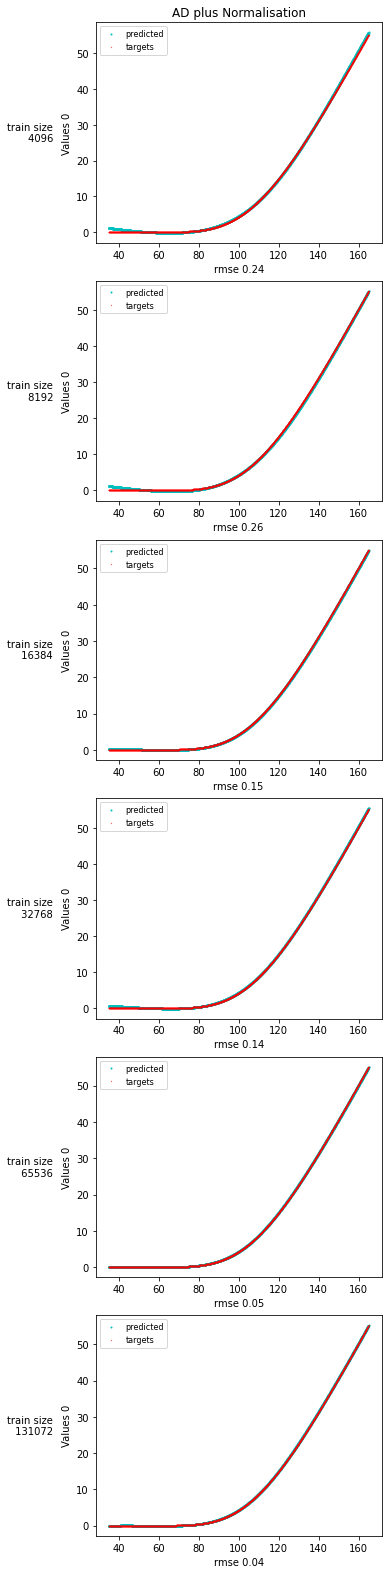

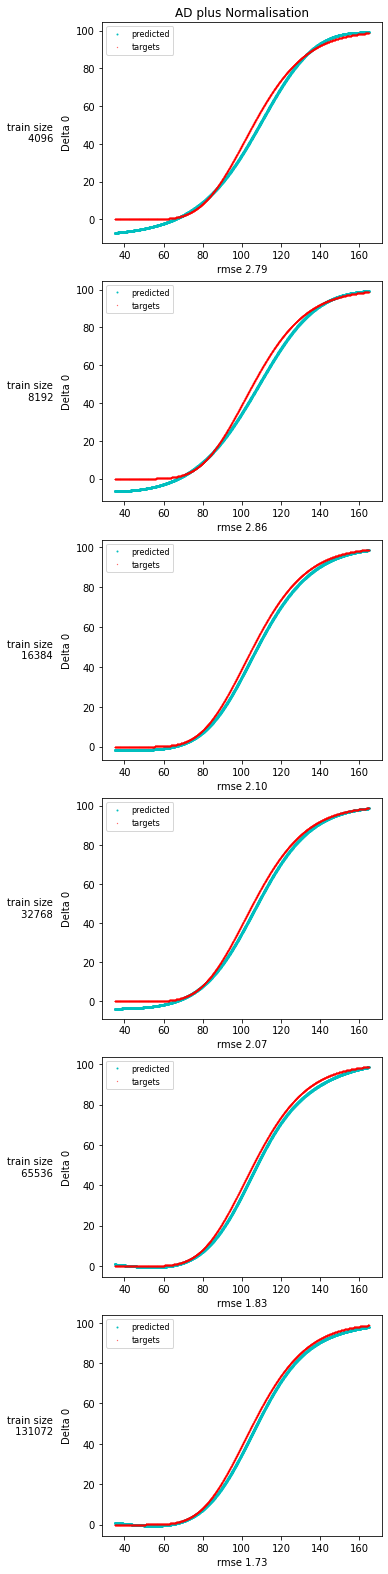

In [23]:
graph(params, pred_values, x_axis_plot, x_axis_name= "", y_axis_name= "Values", targets= y_true_plot, sizes = train_sizes, size_label="train size\n",computeRmse=True)
graph(params, pred_deltas, x_axis_plot, "", "Delta", dydx_true_plot, train_sizes,size_label="train size\n", computeRmse=True)

In [49]:
def vanilla_net(
    input_dim,      # dimension of inputs, e.g. 10
    hidden_units,   # units in hidden layers, assumed constant, e.g. 20
    hidden_layers,  # number of hidden layers, e.g. 4
    seed):          # seed for initialization or None for random
    
    # set seed
    tf.random.set_seed(
    seed)
    
    # input layer
    xs = tf.compat.v1.placeholder(shape=[None, input_dim], dtype=real_type)
    
    # connection weights and biases of hidden layers
    ws = [None]
    bs = [None]
    # layer 0 (input) has no parameters
    
    # layer 0 = input layer
    zs = [xs] # eq.3, l=0
    
    # first hidden layer (index 1)
    # weight matrix
    ws.append(tf.compat.v1.get_variable("w1", [input_dim, hidden_units], \
        initializer = tf.keras.initializers.VarianceScaling(), dtype=real_type))
    # bias vector
    bs.append(tf.compat.v1.get_variable("b1", [hidden_units], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # graph
    zs.append(zs[0] @ ws[1] + bs[1]) # eq. 3, l=1
    
    # second hidden layer (index 2) to last (index hidden_layers)
    for l in range(1, hidden_layers): 
        ws.append(tf.compat.v1.get_variable("w%d"%(l+1), [hidden_units, hidden_units], \
            initializer = tf.keras.initializers.VarianceScaling(), dtype=real_type))
        bs.append(tf.compat.v1.get_variable("b%d"%(l+1), [hidden_units], \
            initializer = tf.zeros_initializer(), dtype=real_type))
        zs.append(tf.nn.softplus(zs[l]) @ ws[l+1] + bs[l+1]) # eq. 3, l=2..L-1

    # output layer (index hidden_layers+1)
    ws.append(tf.compat.v1.get_variable("w"+str(hidden_layers+1), [hidden_units, 1], \
            initializer = tf.keras.initializers.VarianceScaling(), dtype=real_type))
    bs.append(tf.compat.v1.get_variable("b"+str(hidden_layers+1), [1], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # eq. 3, l=L
    zs.append(tf.nn.softplus(zs[hidden_layers]) @ ws[hidden_layers+1] + bs[hidden_layers+1]) 
    
    # result = output layer
    ys = zs[hidden_layers+1]
    
    # return input layer, (parameters = weight matrices and bias vectors), 
    # [all layers] and output layer
    return xs, (ws, bs), zs, ys

In [50]:
def backprop(
    weights_and_biases, # 2nd output from vanilla_net() 
    zs):                # 3rd output from vanilla_net()
    
    ws, bs = weights_and_biases
    L = len(zs) - 1
    
    # backpropagation, eq. 4, l=L..1
    zbar = tf.ones_like(zs[L]) # zbar_L = 1
    for l in range(L-1, 0, -1):
        zbar = (zbar @ tf.transpose(ws[l+1])) * tf.nn.sigmoid(zs[l]) # eq. 4
    # for l=0
    zbar = zbar @ tf.transpose(ws[1]) # eq. 4
    
    xbar = zbar # xbar = zbar_0
    
    # dz[L] / dx
    return xbar    

# combined graph for valuation and differentiation
def twin_net(input_dim, hidden_units, hidden_layers, seed):
    
    # first, build the feedforward net
    xs, (ws, bs), zs, ys = vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # then, build its differentiation by backprop
    xbar = backprop((ws, bs), zs)
    
    # return input x, output y and differentials d_y/d_z
    return xs, ys, xbar

In [51]:
def vanilla_training_graph(input_dim, hidden_units, hidden_layers, seed):
    
    # net
    inputs, weights_and_biases, layers, predictions = \
        vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # backprop even though we are not USING differentials for training
    # we still need them to predict derivatives dy_dx 
    derivs_predictions = backprop(weights_and_biases, layers)
    
    # placeholder for labels
    labels = tf.compat.v1.placeholder(shape=[None, 1], dtype=real_type)
    
    # loss 
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    # optimizer
    learning_rate = tf.compat.v1.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary 
    return inputs, labels, predictions, derivs_predictions, learning_rate, loss, optimizer.minimize(loss)

# training loop for one epoch
def vanilla_train_one_epoch(# training graph from vanilla_training_graph()
                            inputs, labels, lr_placeholder, minimizer,   
                            # training set 
                            x_train, y_train,                           
                            # params, left to client code
                            learning_rate, batch_size, session):        
    
    m, n = x_train.shape
    
    # minimization loop over mini-batches
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

In [60]:
def diff_training_graph(
    # same as vanilla
    input_dim, 
    hidden_units, 
    hidden_layers, 
    seed, 
    # balance relative weight of values and differentials 
    # loss = alpha * MSE(values) + beta * MSE(greeks, lambda_j) 
    # see online appendix
    alpha, 
    beta,
    lambda_j):
    
    # net, now a twin
    inputs, predictions, derivs_predictions = twin_net(input_dim, hidden_units, hidden_layers, seed)
    
    # placeholder for labels, now also derivs labels
    labels = tf.compat.v1.placeholder(shape=[None, 1], dtype=real_type)
    derivs_labels = tf.compat.v1.placeholder(shape=[None, derivs_predictions.shape[1]], dtype=real_type)
    
    # loss, now combined values + derivatives
    loss = alpha * tf.losses.mean_squared_error(labels, predictions) \
    + beta * tf. losses.mean_squared_error(derivs_labels * lambda_j, derivs_predictions * lambda_j)
    
    # optimizer, as vanilla
    learning_rate = tf.compat.v1.placeholder(real_type)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary tensors, including derivatives
    # predictions and labels
    return inputs, labels, derivs_labels, predictions, derivs_predictions, \
            learning_rate, loss, optimizer.minimize(loss)

def diff_train_one_epoch(inputs, labels, derivs_labels, 
                         # graph
                         lr_placeholder, minimizer,             
                         # training set, extended
                         x_train, y_train, dydx_train,          
                         # params
                         learning_rate, batch_size, session):   
    
    m, n = x_train.shape
    
    # minimization loop, now with Greeks
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            derivs_labels: dydx_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

In [53]:
def train(description,
          # neural approximator
          approximator,              
          # training params
          reinit=True, 
          epochs=100, 
          # one-cycle learning rate schedule
          learning_rate_schedule=[    (0.0, 1.0e-8), \
                                      (0.2, 0.1),    \
                                      (0.6, 0.01),   \
                                      (0.9, 1.0e-6), \
                                      (1.0, 1.0e-8)  ], 
          batches_per_epoch=16,
          min_batch_size=256,
          # callback function and when to call it
          callback=None,           # arbitrary callable
          callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
    # batching
    batch_size = max(min_batch_size, approximator.m // batches_per_epoch)
    
    # one-cycle learning rate sechedule
    lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)
            
    # reset
    if reinit:
        approximator.session.run(approximator.initializer)
    
    # callback on epoch 0, if requested
    if callback and 0 in callback_epochs:
        callback(approximator, 0)
        
    # loop on epochs, with progress bar (tqdm)
    for epoch in tqdm_notebook(range(epochs), desc=description):
        
        # interpolate learning rate in cycle
        learning_rate = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)
        
        # train one epoch
        
        if not approximator.differential:
        
            vanilla_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                learning_rate, 
                batch_size, 
                approximator.session)
        
        else:
        
            diff_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.derivs_labels,
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                approximator.dy_dx,
                learning_rate, 
                batch_size, 
                approximator.session)
        
        # callback, if requested
        if callback and epoch in callback_epochs:
            callback(approximator, epoch)

    # final callback, if requested
    if callback and epochs in callback_epochs:
        callback(approximator, epochs)   

In [54]:
epsilon = 1.0e-08
def normalize_data(x_raw, y_raw, dydx_raw=None, crop=None):
    
    # crop dataset
    m = crop if crop is not None else x_raw.shape[0]
    x_cropped = x_raw[:m]
    y_cropped = y_raw[:m]
    dycropped_dxcropped = dydx_raw[:m] if dydx_raw is not None else None
    
    # normalize dataset
    x_mean = x_cropped.mean(axis=0)
    x_std = x_cropped.std(axis=0) + epsilon
    x = (x_cropped- x_mean) / x_std
    y_mean = y_cropped.mean(axis=0)
    y_std = y_cropped.std(axis=0) + epsilon
    y = (y_cropped-y_mean) / y_std
    
    # normalize derivatives too
    if dycropped_dxcropped is not None:
        dy_dx = dycropped_dxcropped / y_std * x_std 
        # weights of derivatives in cost function = (quad) mean size
        lambda_j = 1.0 / np.sqrt((dy_dx ** 2).mean(axis=0)).reshape(1, -1)
    else:
        dy_dx = None
        lambda_j = None
    
    return x_mean, x_std, x, y_mean, y_std, y, dy_dx, lambda_j

In [64]:
class Neural_Approximator():
    
    def __init__(self, x_raw, y_raw, 
                 dydx_raw=None):      # derivatives labels, 
       
        self.x_raw = x_raw
        self.y_raw = y_raw
        self.dydx_raw = dydx_raw
        
        # tensorflow logic
        self.graph = None
        self.session = None
                        
    def __del__(self):
        if self.session is not None:
            self.session.close()
        
    def build_graph(self,
                differential,       # differential or not           
                lam,                # balance cost between values and derivs  
                hidden_units, 
                hidden_layers, 
                weight_seed):
        
        # first, deal with tensorflow logic
        if self.session is not None:
            self.session.close()

        self.graph = tf.Graph()
        
        with self.graph.as_default():
        
            # build the graph, either vanilla or differential
            self.differential = differential
            
            if not differential:
            # vanilla 
                
                self.inputs, \
                self.labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer \
                = vanilla_training_graph(self.n, hidden_units, hidden_layers, weight_seed)
                    
            else:
            # differential
            
                if self.dy_dx is None:
                    raise Exception("No differential labels for differential training graph")
            
                self.alpha = 1.0 / (1.0 + lam * self.n)
                self.beta = 1.0 - self.alpha
                
                self.inputs, \
                self.labels, \
                self.derivs_labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer = diff_training_graph(self.n, hidden_units, \
                                                     hidden_layers, weight_seed, \
                                                     self.alpha, self.beta, self.lambda_j)
        
            # global initializer
            self.initializer = tf.compat.v1.global_variables_initializer()
            
        # done
        self.graph.finalize()
        self.session = tf.compat.v1.Session(graph=self.graph)
                        
    # prepare for training with m examples, standard or differential
    def prepare(self, 
                m, 
                differential,
                lam=1,              # balance cost between values and derivs  
                # standard architecture
                hidden_units=20, 
                hidden_layers=4, 
                weight_seed=None):

        # prepare dataset
        self.x_mean, self.x_std, self.x, self.y_mean, self.y_std, self.y, self.dy_dx, self.lambda_j = \
            normalize_data(self.x_raw, self.y_raw, self.dydx_raw, m)
        
        # build graph        
        self.m, self.n = self.x.shape        
        self.build_graph(differential, lam, hidden_units, hidden_layers, weight_seed)
        
    def train(self,            
              description="training",
              # training params
              reinit=True, 
              epochs=100, 
              # one-cycle learning rate schedule
              learning_rate_schedule=[
                  (0.0, 1.0e-8), 
                  (0.2, 0.1), 
                  (0.6, 0.01), 
                  (0.9, 1.0e-6), 
                  (1.0, 1.0e-8)], 
              batches_per_epoch=16,
              min_batch_size=256,
              # callback and when to call it
              # we don't use callbacks, but this is very useful, e.g. for debugging
              callback=None,           # arbitrary callable
              callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
        train(description, 
              self, 
              reinit, 
              epochs, 
              learning_rate_schedule, 
              batches_per_epoch, 
              min_batch_size,
              callback, 
              callback_epochs)
     
    def predict_values(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std 
        # predict scaled
        y_scaled = self.session.run(self.predictions, feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        return y

    def predict_values_and_derivs(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std
        # predict scaled
        y_scaled, dyscaled_dxscaled = self.session.run(
            [self.predictions, self.derivs_predictions], 
            feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        dydx = self.y_std / self.x_std * dyscaled_dxscaled
        return y, dydx

In [97]:
def test(generator, 
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = x_train, y_train, dydx_train
    xTest, xAxis, yTest, dydxTest, v = x_true, x_axis, y_true, dydx_true, vegas
    print("done")

    # neural approximator
    print("initializing neural appropximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
            
        print("\nsize %d" % size)
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        start = timer()
        regressor.train("differential training")
        end = timer()
        print("Training of %s data takes %s time" %(size,end-start))
        
        start = timer()
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        end = timer()
        print("Predicting of %s data takes %s time" %(size,end-start))
        predvalues[("differential", size)] = predictions
        preddeltas[("differential", size)] = deltas[:, deltidx]
        
    return xAxis, yTest, dydxTest[:, deltidx], v, predvalues, preddeltas

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 1

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()

In [98]:
sizes = [4096, 8192, 16384, 32768, 65536, 131072]
showDeltas = True

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
weightSeed = None

# number of test scenarios
nTest = 4096    

# go
generator = BlackScholes()
xAxis, yTest, dydxTest, v, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 1267
simulating training, valid and test sets
done
initializing neural appropximator
done

size 4096


<ipython-input-53-4c2ecea914b6>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 4096 data takes 6.287197000005108 time
Predicting of 4096 data takes 0.01981779999914579 time

size 8192


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 8192 data takes 6.105365499999607 time
Predicting of 8192 data takes 0.01871709999977611 time

size 16384


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 16384 data takes 7.005389699996158 time
Predicting of 16384 data takes 0.0210877999998047 time

size 32768


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 32768 data takes 6.739496999995026 time
Predicting of 32768 data takes 0.020822800004680175 time

size 65536


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 65536 data takes 6.696571899999981 time
Predicting of 65536 data takes 0.01883809999708319 time

size 131072


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 131072 data takes 8.14474760000303 time
Predicting of 131072 data takes 0.03084540000418201 time


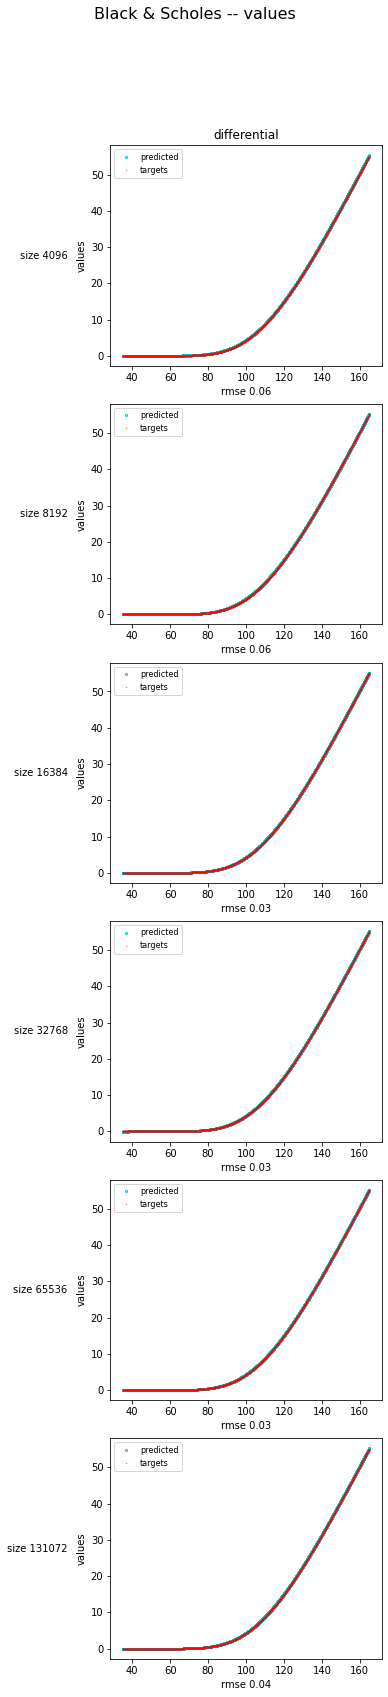

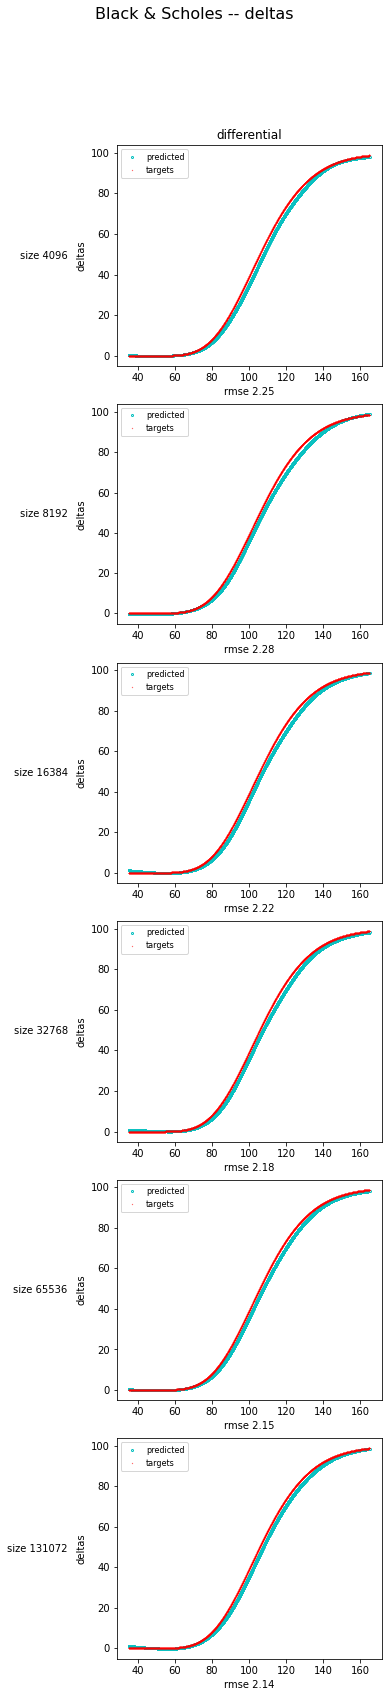

In [99]:
graph("Black & Scholes", values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Black & Scholes", deltas, xAxis, "", "deltas", dydxTest, sizes, True)

In [73]:
def stoc_bond_price(dynamics, contract):
    """
    Function that computes the analytical zero-coupon bond price given vasicek interest rate model 
    """
    
    theta, mu, sigma, r0, t = dynamics.theta, dynamics.mu, dynamics.sigma, dynamics.r0, contract.T
    
    A = (1-np.exp(-theta*t))/theta
    D = (mu - (sigma**2)/(2*(theta)**2))*(A-t) - ((sigma**2)*A**2)/(4*theta)
    
    return np.exp(-A*r0+D)


def diff_bond_price(dynamics, contract):
    """
    Function that computes the analytical zero-coupon bond price  sensitivity wrt r_0 given vasicek interest rate model 
    """
    
    theta, mu, sigma, r0, T = dynamics.theta, dynamics.mu, dynamics.sigma, dynamics.r0, contract.T
    
    A = (1-np.exp(-theta*T))/theta
    D = (mu - (sigma**2)/(2*(theta)**2))*(A-T) - ((sigma**2)*A**2)/(4*theta)
    
    return -A*np.exp(D-A*r0)


def forward_exchange_rate(X0, dynamics_f, dynamics_d, contract):
    """
    Function that computes the analytical price of a forward exchange rate given the parameters of 2 short rate following ornstein-uhlenbeck SDE 
    """
    
    bond_f = stoc_bond_price(dynamics_f, contract)
    bond_d = stoc_bond_price(dynamics_d, contract)
    
    return X0*bond_f/bond_d

In [74]:
class Dynamics:
    pass
domestics_bond = Dynamics()
domestics_bond.r0 = 0.04
domestics_bond.theta = 3
domestics_bond.mu = 0.05
domestics_bond.sigma = 0.08

foreign_bond = Dynamics()
foreign_bond.r0 = 0.10
foreign_bond.theta = 4
foreign_bond.mu = 0.08
foreign_bond.sigma = 0.12

class Contract:
    pass

contract = Contract()
contract.T = 1 

class FD:
    pass

#Explicit Scheme

fd_dom = FD()
fd_dom.rMax=0.35
fd_dom.rMin=-0.1
fd_dom.deltat=contract.T/10000
fd_dom.deltar=np.min([domestics_bond.sigma**2,0.05])


fd_for = FD()
fd_for.rMax=0.35
fd_for.rMin=-0.1
fd_for.deltat=contract.T/10000
fd_for.deltar=np.min([foreign_bond.sigma**2,0.05])

#CN Scheme
fd_dom2 = FD()
fd_dom2.rMax=0.35
fd_dom2.rMin=-0.1
fd_dom2.deltat=contract.T/10000
fd_dom2.deltar=domestics_bond.sigma*np.sqrt(fd_dom2.deltat) 


fd_for2 = FD()
fd_for2.rMax=0.35
fd_for2.rMin=-0.1
fd_for2.deltat=contract.T/10000
fd_for2.deltar=foreign_bond.sigma*np.sqrt(fd_for2.deltat)

In [79]:
def vasicek(dynamics,contract, N=1000, seed=767, simulations=10000):    
    """ Produces the stochastic paths of a vasicek SDE"""
    
    #np.random.seed(seed)
    r0,theta,mu,sigma,T=dynamics.r0,dynamics.theta,dynamics.mu,dynamics.sigma,contract.T
    dt = T/float(N)
    mean_vasicek=lambda t:np.exp(-theta*t)*(r0+mu*(np.exp(theta*t)-1))
    var_vasicek=lambda t:((1-np.exp(-2*theta*t))/2*theta)*sigma**2
    normal_matrix=np.random.standard_normal(size=(simulations,N+1))
    rates_paths=np.add(np.array([mean_vasicek(dt*t_) for t_ in range(N+1)]),np.sqrt([var_vasicek(dt*t_) for t_ in range(N+1)])*normal_matrix)
        
    return [x*dt for x in range(N+1)], rates_paths
def pricer_bond_vasicek_MonteCarlo(dynamics,contract,N=1000, seed=767, simulations=10000):
    """
    Returns the price of a Bond Contract using Monte-Carlo simulation
    """ 
    t,rates=vasicek(dynamics,contract,N=N, seed=seed, simulations=simulations)
    num_paths=len(rates)
    dt=t[1]
    exp_integrals=[np.exp(-(np.array(rates[i])*dt).sum()) for i in range(num_paths)]
        
    return np.mean(exp_integrals)


def price_diff_bond_vasicek_MonteCarlo(dynamics,contract,N=100, seed=767, simulations=1):
    """
    Returns the price of a Bond Contract using Monte-Carlo simulation and it's sensitivity w.r.t r_0
    """ 
    t,rates=vasicek(dynamics,contract,N=N, seed=seed, simulations=simulations)
    num_paths=len(rates)
    dt=t[1]
    exp_integrals=np.array([np.exp(-(np.array(rates[i])*dt).sum()) for i in range(num_paths)])
        
    return np.mean(exp_integrals), -exp_integrals*((1-np.exp(-dynamics.theta*contract.T))/dynamics.theta)

In [75]:
class VasicekBond:
    
    def __init__(self, 
                 dynamics,
                 contract, T1=0.5):
        
        self.dynamics = Dynamics()
        self.dynamics.r0 = dynamics.r0
        self.dynamics.theta = dynamics.theta
        self.dynamics.mu = dynamics.mu
        self.dynamics.sigma = dynamics.sigma
        self.contract_T2=Contract()
        self.contract_T2.T = contract.T
        self.contract_T1= Contract()
        self.contract_T1.T=max(self.contract_T2.T-T1,0)
                        
    # training set: returns r_1 (mx1), B_T (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, seed=None):
    
        np.random.seed(seed)
    
        # rates at (T-t) - inputs FF
        t,paths=vasicek(self.dynamics,self.contract_T1,N=1, seed=seed, simulations=m) #check contract here (Time)
        X = np.squeeze(np.delete(paths, 0, 1))
        # payoff - labels
        Y = np.zeros(m)
        #differentials - inputs BP 
        Z = np.zeros(m)
       
        for i in range(m):
            self.dynamics.r0=X[i]
            Y[i],Z[i]=price_diff_bond_vasicek_MonteCarlo(self.dynamics,self.contract_T1,N=100, seed=seed, simulations=1)
           
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices
    def testSet(self, lower=-0.35, upper=0.5, num=100, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, diffs
        prices=np.zeros(num)
        diffs=np.zeros(num)
        for i in range(num):
            self.dynamics.r0=spots[i]
            prices[i]=stoc_bond_price(self.dynamics,self.contract_T1)
            diffs[i]=diff_bond_price(self.dynamics,self.contract_T1)

        return spots.reshape((-1, 1)), spots.reshape((-1, 1)), prices.reshape((-1, 1)), diffs.reshape((-1, 1))

In [88]:
generator = VasicekBond(domestics_bond,contract)
simulSeed = 23333
testSeed = 233
x_train_vas, y_train_vas, dydx_train_vas = generator.trainingSet(max(train_sizes), seed=simulSeed)
x_true_vas, x_axis_vas, y_true_vas, dydx_true_vas= generator.testSet(num=32768, seed=testSeed)

In [89]:
pred_values_vas = {}    
pred_deltas_vas = {}
x_axis_plot_vas = {}
y_true_plot_vas = {}
deltidx = 0 # show delta to first stock
dydx_true_plot_vas = {} # delta for deltidx
params_vas = {}
params_vas[('colid')] = ['AD_Vas']
params_vas[('coltitle',0)] = 'AD plus Normalisation Vasicek'
params_vas[('type')] = "sz"
params_vas[('pic_name')]='AD'

In [90]:
for size in train_sizes:

    x_axis_plot_vas[(size)] = x_axis_vas
    y_true_plot_vas[(size)] = y_true_vas
    dydx_true_plot_vas[(size)] = dydx_true_vas

    # Autodiff
    tf.keras.backend.clear_session()
    prep_layer, scaled_MSE =  preprocess_data(x_train_vas, y_train_vas, dydx_train_vas, prep_type='Normalisation')
    model = build_and_compile_model(prep_layer.output_n(),
                                        get_model_autodiff,
                                        scaled_MSE, 
                                        differential_weight,
                                        lr_schedule = lr_inv_time_decay  # lr_inv_time_decay lr_warmup
                                        )
    start = timer()
    history = train_model(  model,
                            prep_layer,
                             f"{params_vas['type']:s}/{params_vas['colid'][0]:s}_{size}",
                            x_train_vas[0:size,:], 
                            y_train_vas[0:size,:], 
                            dydx_train_vas[0:size,:], 
                            epochs=EPOCHS,
                            x_true = x_true_vas, 
                            y_true = y_true_vas, 
                            dydx_true = dydx_true_vas
                            )
    end = timer()
    print("Training of %s data takes %s time" %(size,end-start))
    start = timer()
    y_pred_vas, dydx_pred_vas = predict_unscaled(model, prep_layer, x_true_vas)
    end = timer()
    print("Predicting of %s data takes %s time" %(size,end-start))
    pred_values_vas[(params_vas['colid'][0], size)] = y_pred_vas
    pred_deltas_vas[(params_vas['colid'][0], size)] = dydx_pred_vas

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 4096 data takes 31.022737999999663 time
Predicting of 4096 data takes 2.315545799996471 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 8192 data takes 46.69406929999968 time
Predicting of 8192 data takes 2.1828814999971655 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 16384 data takes 69.5755771999975 time
Predicting of 16384 data takes 2.9082717999990564 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 32768 data takes 108.43032849999872 time
Predicting of 32768 data takes 2.064707500001532 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 65536 data takes 121.07642300000589 time
Predicting of 65536 data takes 1.8222318999978597 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 131072 data takes 216.76222720000078 time
Predicting of 131072 data takes 2.9782027999972343 time


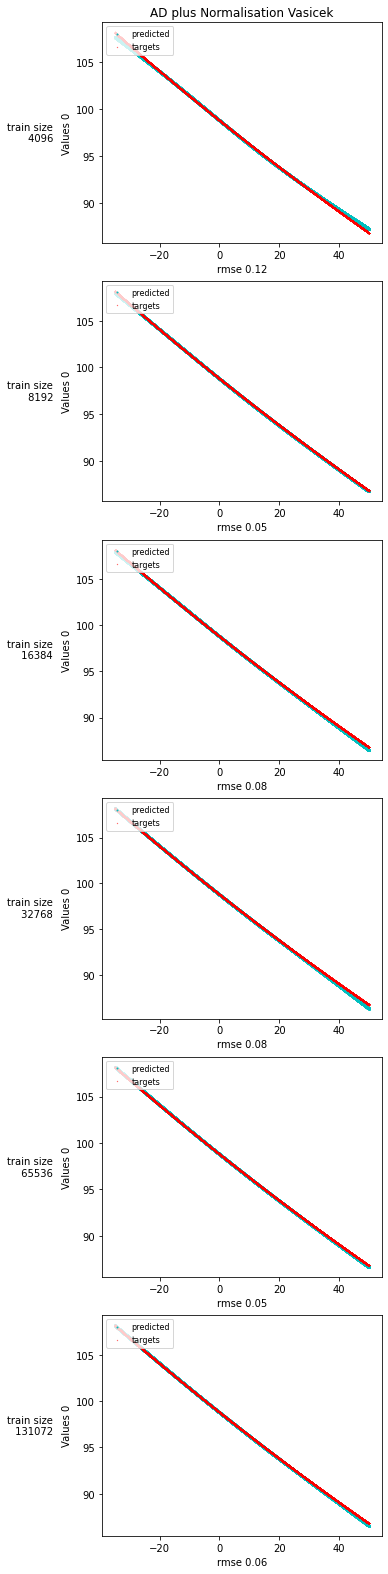

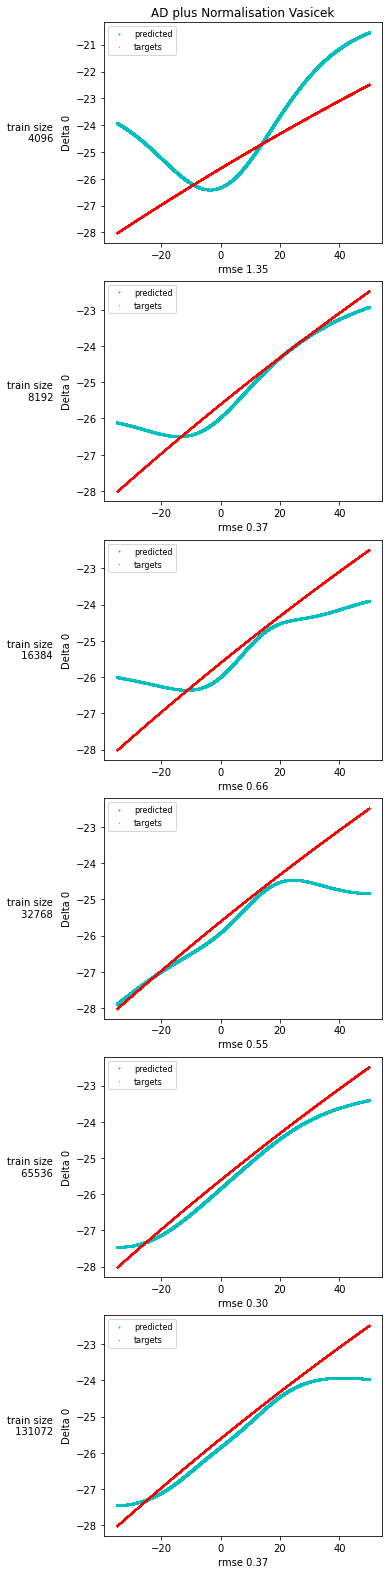

In [91]:
graph(params_vas, pred_values_vas, x_axis_plot_vas, x_axis_name= "", y_axis_name= "Values", targets= y_true_plot_vas, sizes = train_sizes, size_label="train size\n",computeRmse=True)
graph(params_vas, pred_deltas_vas, x_axis_plot_vas, "", "Delta", dydx_true_plot_vas, train_sizes,size_label="train size\n", computeRmse=True)

In [100]:
def test(generator, 
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = x_train_vas, y_train_vas, dydx_train_vas
    xTest, xAxis, yTest, dydxTest = x_true_vas, x_axis_vas, y_true_vas, dydx_true_vas
    print("done")

    # neural approximator
    print("initializing neural appropximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
            
        print("\nsize %d" % size)
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        start = timer()
        regressor.train("differential training")
        end = timer()
        print("Training of %s data takes %s time" %(size,end-start))
        
        start = timer()
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        end = timer()
        print("Predicting of %s data takes %s time" %(size,end-start))
        predvalues[("differential", size)] = predictions
        preddeltas[("differential", size)] = deltas[:, deltidx]
        
    return xAxis, yTest, dydxTest[:, deltidx], v, predvalues, preddeltas

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 1

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()

In [102]:
nTest = 32768    

# go
xAxis, yTest, dydxTest, v, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

simulating training, valid and test sets
done
initializing neural appropximator
done

size 4096


<ipython-input-53-4c2ecea914b6>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 4096 data takes 6.576111800000945 time
Predicting of 4096 data takes 0.02114429999346612 time

size 8192


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 8192 data takes 6.429697799998394 time
Predicting of 8192 data takes 0.02084130000002915 time

size 16384


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 16384 data takes 6.197950399997353 time
Predicting of 16384 data takes 0.022096599997894373 time

size 32768


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 32768 data takes 5.805140800002846 time
Predicting of 32768 data takes 0.02255880000302568 time

size 65536


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 65536 data takes 6.742164600000251 time
Predicting of 65536 data takes 0.01959530000021914 time

size 131072


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

Training of 131072 data takes 7.795650200001546 time
Predicting of 131072 data takes 0.01885230000334559 time


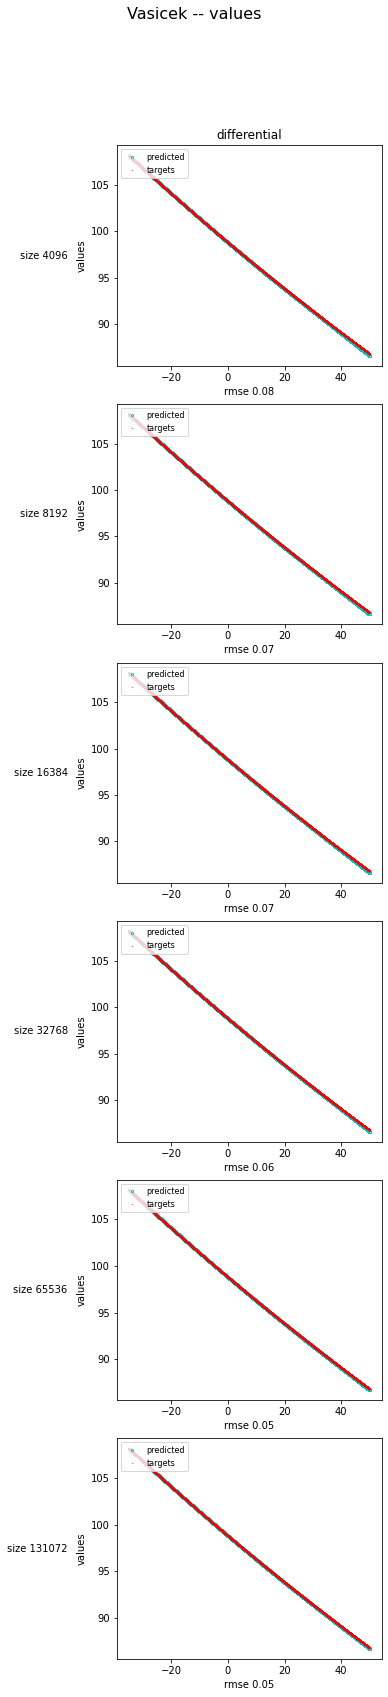

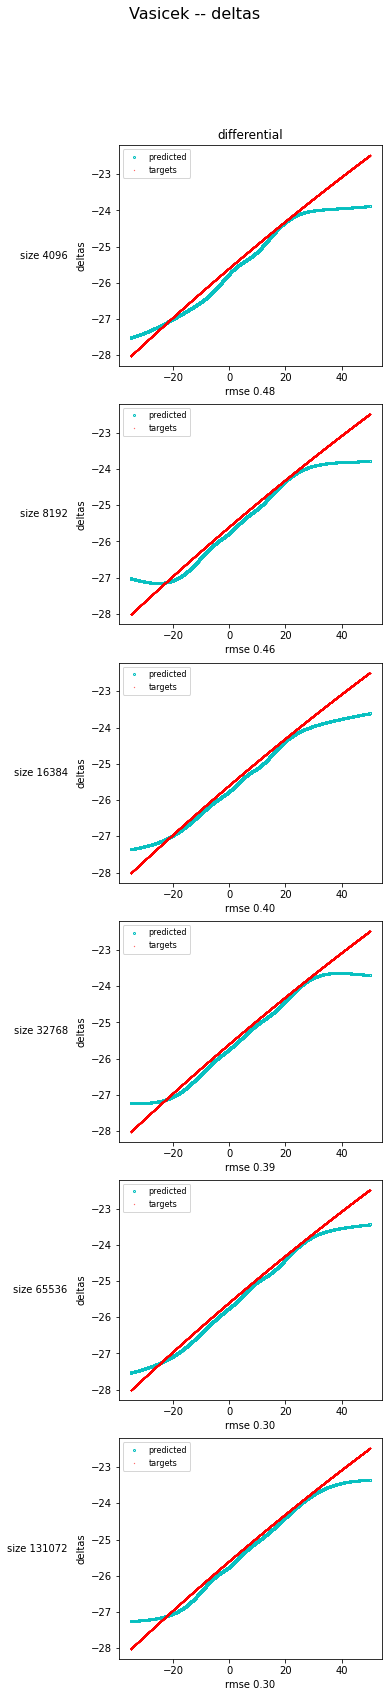

In [103]:
graph("Vasicek", values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Vasicek", deltas, xAxis, "", "deltas", dydxTest, sizes, True)

In [104]:
def bsFXPrice(dynamics,contract):
    S0, vol, rd, rf= dynamics.S0, dynamics.sigma, dynamics.rd, dynamics.rf
    K, T = contract.K, contract.T 
    F=S0*np.exp((rd-rf)*T)
    d1 = (np.log(F/K) + (0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(F/K) - (0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return S0*np.exp(-rf*T) * norm.cdf(d1) - K*np.exp(-rd*T) * norm.cdf(d2)

def bsFXDelta(dynamics,contract):
    S0, vol, rd, rf= dynamics.S0, dynamics.sigma, dynamics.rd, dynamics.rf
    K, T = contract.K, contract.T
    F=S0*np.exp((rd-rf)*T)
    d1 = (np.log(F/K) + 0.5 * vol * vol * T) / (vol * np.sqrt(T))
    return np.exp((-rf)*T)*norm.cdf(d1)

In [105]:
class BlackScholesFX:
    
    def __init__(self, 
                 dynamics,
                 contract,
                 T1=0.5,
                 volMult=1.0):
        
        self.dynamics = Dynamics()
        self.dynamics.S0 = dynamics.S0
        self.dynamics.rd = dynamics.rd
        self.dynamics.rf = dynamics.rf
        self.dynamics.sigma = dynamics.sigma
        self.contract_T2=Contract()
        self.contract_T2.T = contract.T
        self.contract_T2.K=contract.K
        self.contract_T1= Contract()
        self.contract_T1.T=T1
        self.contract_T1.K=contract.K
        
        self.spot = self.dynamics.S0
        self.vol =  self.dynamics.sigma
        self.rf=self.dynamics.rf
        self.rd=self.dynamics.rd
        self.T1 = T1
        self.T2 = self.contract_T2.T
        self.K = self.contract_T2.K
        self.volMult = volMult
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
    
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        R1 = np.exp((self.rd-self.rf-0.5*vol0*vol0)*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp((self.rd-self.rf-0.5*self.vol*self.vol)*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, np.exp(-self.rd*self.T2)*(S2 - self.K))
        
        # two antithetic paths
        if anti:
            
            R2a = np.exp((self.rd-self.rf-0.5*self.vol*self.vol)*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, np.exp(-self.rd*self.T2)*(S2a - self.K))
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(np.exp(-self.rd*self.T2)*S2 > np.exp(-self.rd*self.T2)*self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(np.exp(-self.rd*self.T2)*S2a > np.exp(-self.rd*self.T2)*self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(np.exp(-self.rd*self.T2)*S2 > np.exp(-self.rd*self.T2)*self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas
    def testSet(self, lower=0.8, upper=1.15, num=1000, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas 
        prices=np.zeros(num)
        deltas=np.zeros(num)
        
        for i in range(num):
            self.dynamics.S0=spots[i]
            prices[i]=bsFXPrice(self.dynamics,self.contract_T1)
            deltas[i]=bsFXDelta(self.dynamics,self.contract_T1)
        
        prices = prices.reshape((-1, 1))
        deltas = deltas.reshape((-1, 1))
        return spots, spots, prices, deltas  

In [106]:
class Dynamics:
    pass
fxrate = Dynamics()
fxrate.rd = 0.04
fxrate.rf = 0.02
fxrate.sigma = 0.1
fxrate.S0=1

class Contract:
    pass

contract = Contract()
contract.T = 1
contract.K=1.05

class FD:
    pass

fd = FD()
fd.SMax=1.35
fd.SMin=0.02
fd.deltat=contract.T/10000
fd.deltas=fxrate.sigma*np.sqrt(fd.deltat) 

class MC:
    pass

mc=MC()
mc.N=1000
mc.M=1000
mc.epsilon=10e-5
mc.seed=0



In [107]:
generator = BlackScholesFX(fxrate,contract)
x_train_BSFX, y_train_BSFX, dydx_train_BSFX = generator.trainingSet(max(train_sizes), seed=simulSeed)
x_true_BSFX, x_axis_BSFX, y_true_BSFX, dydx_true_BSFX= generator.testSet(num=32768, seed=testSeed)

In [108]:
pred_values_BSFX = {}    
pred_deltas_BSFX = {}
x_axis_plot_BSFX = {}
y_true_plot_BSFX = {}
deltidx = 0 # show delta to first stock
dydx_true_plot_BSFX = {} # delta for deltidx
params_BSFX = {}
params_BSFX[('colid')] = ['AD_BSFX']
params_BSFX[('coltitle',0)] = 'AD plus Normalisation BSFX'
params_BSFX[('type')] = "sz"
params_BSFX[('pic_name')]='AD'

In [114]:
for size in train_sizes:

    x_axis_plot_BSFX[(size)] = x_axis_BSFX
    y_true_plot_BSFX[(size)] = y_true_BSFX
    dydx_true_plot_BSFX[(size)] = dydx_true_BSFX

    # Autodiff
    tf.keras.backend.clear_session()
    prep_layer, scaled_MSE =  preprocess_data(x_train_BSFX, y_train_BSFX, dydx_train_BSFX, prep_type='Normalisation')
    model = build_and_compile_model(prep_layer.output_n(),
                                        get_model_autodiff,
                                        scaled_MSE, 
                                        differential_weight,
                                        lr_schedule = lr_inv_time_decay  # lr_inv_time_decay lr_warmup
                                        )
    start = timer()
    history = train_model(  model,
                            prep_layer,
                             f"{params_BSFX['type']:s}/{params_BSFX['colid'][0]:s}_{size}",
                            x_train_BSFX[0:size,:], 
                            y_train_BSFX[0:size,:], 
                            dydx_train_BSFX[0:size,:], 
                            epochs=EPOCHS,
                            x_true = x_true_BSFX, 
                            y_true = y_true_BSFX, 
                            dydx_true = dydx_true_BSFX
                            )
    end = timer()
    print("Training of %s data takes %s time" %(size,end-start))
    start = timer()
    y_pred_BSFX, dydx_pred_BSFX = predict_unscaled(model, prep_layer, x_true_BSFX)
    end = timer()
    print("Predicting of %s data takes %s time" %(size,end-start))
    pred_values_BSFX[(params_BSFX['colid'][0], size)] = y_pred_BSFX
    pred_deltas_BSFX[(params_BSFX['colid'][0], size)] = dydx_pred_BSFX

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 4096 data takes 34.28710590000264 time
Predicting of 4096 data takes 2.016399999993155 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 8192 data takes 49.42435470000055 time
Predicting of 8192 data takes 2.1791626999984146 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 16384 data takes 61.11305530000391 time
Predicting of 16384 data takes 2.359505000000354 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 32768 data takes 92.37345949999872 time
Predicting of 32768 data takes 2.437340700002096 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 65536 data takes 115.2804965999967 time
Predicting of 65536 data takes 6.180009499999869 time


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training of 131072 data takes 306.30341939999926 time
Predicting of 131072 data takes 2.5739771999942604 time


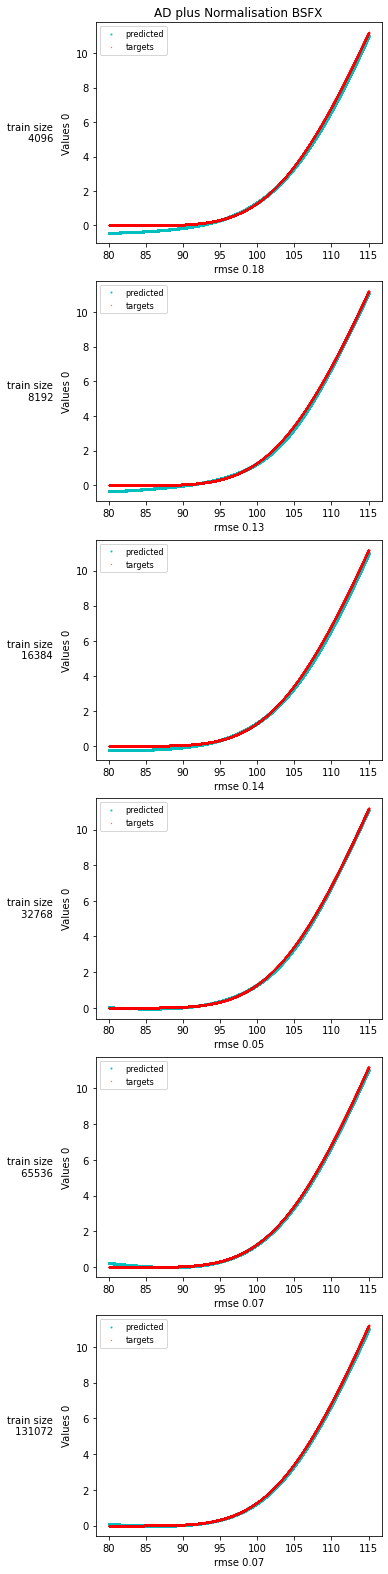

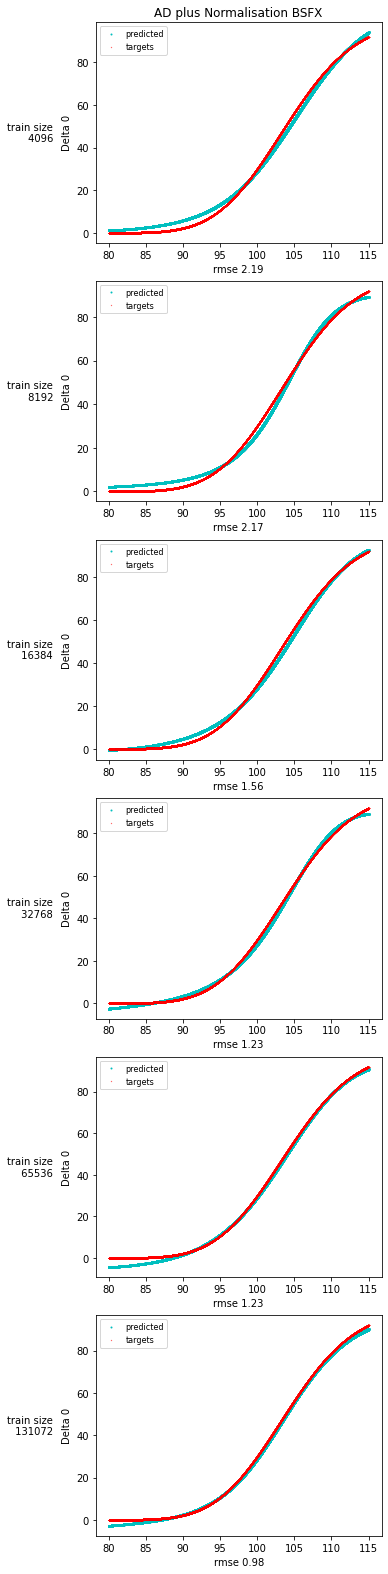

In [115]:
graph(params_BSFX, pred_values_BSFX, x_axis_plot_BSFX, x_axis_name= "", y_axis_name= "Values", targets= y_true_plot_BSFX, sizes = train_sizes, size_label="train size\n",computeRmse=True)
graph(params_BSFX, pred_deltas_BSFX, x_axis_plot_BSFX, "", "Delta", dydx_true_plot_BSFX, train_sizes,size_label="train size\n", computeRmse=True)

In [116]:
def call_FX_GK_CrankNicolson(contract,dynamics,FD):
    """
    returns array of all initial short rates,
    and the corresponding array of zero-coupon
    T-maturity bond prices
    """ 
    volcoeff, S0,rf,rd=dynamics.sigma, dynamics.S0, dynamics.rf, dynamics.rd
    
    T,K=contract.T,contract.K

 # SMin and SMax denote the smallest and largest S in the _interior_.
    # The boundary conditions are imposed one step _beyond_, 
    # e.g. at S_lowboundary=SMin-deltaS, not at SMin.
    # To relate to lecture notation, S_lowboundary is S_{-J}
    # whereas SMin is S_{-J+1}

    SMax=FD.SMax
    SMin=FD.SMin
    deltaS=FD.deltas
    deltat=FD.deltat
    N=round(T/deltat)
    
    if abs(N-T/deltat)>1e-12:
        raise ValueError('Bad time step')
    numS=round((SMax-SMin)/deltaS)+1
    if abs(numS-(SMax-SMin)/deltaS-1)>1e-12:
        raise ValueError('Bad time step')
    S=np.linspace(SMax,SMin,numS)    #The FIRST indices in this array are for HIGH levels of S
    S_highboundary=SMax+deltaS

    callprice=np.maximum(S-K,0)
    
    ratio=deltat/deltaS
    ratio2=deltat/deltaS**2
    
    f = 0.5*(volcoeff**2)*S**2  
    g = (rd-rf)*S
    h = -rd 
    
    F = 0.5*ratio2*f+0.25*ratio*g
    G = ratio2*f-0.5*deltat*h
    H = 0.5*ratio2*f-0.25*ratio*g
    
    RHSmatrix = diags([H[:-1], 1-G, F[1:]], [1,0,-1], shape=(numS,numS), format="csr")
    LHSmatrix = diags([-H[:-1], 1+G, -F[1:]], [1,0,-1], shape=(numS,numS), format="csr")
    # diags creates SPARSE matrices
    
    for t in np.arange(N-1,-1,-1)*deltat:
        rhs = RHSmatrix * callprice
    
        #boundary condition vectors.
        #They are nonzero only in the first component:
        rhs[0]=rhs[0]+2*H[0]*(S_highboundary-K) #Boundary
        callprice = spsolve(LHSmatrix, rhs)
    
    return(S, callprice)

In [117]:
def two_closest(lst, K): 
    """
    Function that find the closest upper and lower element in an array
    """
    
    pos_arr = lst[(lst-K) > 0]
    neg_arr = lst[(K-lst) > 0]
    
    min_val = neg_arr[(np.abs(neg_arr - K)).argmin()]
    max_val = pos_arr[(np.abs(pos_arr - K)).argmin()]
    
    return min_val, max_val

def interpolate_rate(r_arr, bondprice, r0):
    """
    Find the interpolate value of a bond for a given rate of interest based on grid of values 
    """
    
    r_low, r_high = two_closest(r_arr, r0)
    bond_low = bondprice[np.where(r_arr == r_low)[0][0]]
    bond_high = bondprice[np.where(r_arr == r_high)[0][0]]
    
    x = [r_low, r_high]
    y = [bond_low, bond_high]
    f = interpolate.interp1d(x,y)
    
    return f(r0)

In [119]:
def call_FX_GK_MC(contract,dynamics,MC):

    np.random.seed(MC.seed)  #seed the random number generator
    
    # You complete the coding of this function
        
    S0, sigma, rd, rf= dynamics.S0, dynamics.sigma, dynamics.rd, dynamics.rf
    K, T = contract.K, contract.T
    N, M, epsilon = MC.N, MC.M, MC.epsilon
    
    deltat = T/N
    C = []
    SE = []
    
    z = np.random.randn(N,M)
    for S in [S0, S0+epsilon]:
        x = S
        for t in range(N):
            zm = z[t]
            x = x + (rd-rf)*deltat + sigma*zm*np.sqrt(deltat)
        s = x
        # discounted payoff
        payoff = np.maximum(s-K,0)*np.exp(-rd*T)
        C.append(np.mean(payoff))
        SE.append(np.std(payoff, ddof=1)/np.sqrt(M))
    
    call_price = C[0]
    standard_error = SE[0]
    call_delta = (C[1]-C[0])/epsilon
    
        
    return(call_price, standard_error, call_delta)

In [120]:
start = time.time()
(fxspot, callprice) = call_FX_GK_CrankNicolson(contract,fxrate,fd)
end = time.time()
txt="Crank-Nicolson method: {time:.2f} seconds"
print(txt.format(time = end - start))


fxrate2 = Dynamics()
fxrate2.rd = 0.04
fxrate2.rf = 0.02
fxrate2.sigma = 0.1
fxrate2.S0=1
num_prices=100
fxspot_mc = np.linspace(fd.SMin,fd.SMax, num_prices)
callprice_mc=[]

start = time.time()
for S_ in fxspot_mc:
    fxrate2.S0 = S_
    call,error,delta=call_FX_GK_MC(contract,fxrate2,mc)
    callprice_mc.append(call)
end = time.time()
txt="Monte Carlo method: {time:.2f} seconds"
print(txt.format(time = end - start))

Crank-Nicolson method: 5.01 seconds
Monte Carlo method: 4.34 seconds


In [122]:
N=1000
s=8192
spot_charts = np.linspace(0.95,1.07, N)
call_fx_cn = np.zeros(N)
call_fx_mc = np.zeros(N)
call_fx_dml= np.zeros(N)
call_fx_analytical = np.zeros(N)

callprice_dml=[ c[0] for c in values[("differential", s)].tolist()]

for i, S_ in enumerate(tqdm(spot_charts)):
    fxrate2.S0=S_
    call_fx_analytical[i]=bsFXPrice(fxrate2,contract)
    call_fx_cn[i]=interpolate_rate(fxspot,callprice,S_)
    call_fx_dml[i]=interpolate_rate(x_axis_BSFX,callprice_dml,S_)
    call_fx_mc[i]=interpolate_rate(fxspot_mc,callprice_mc,S_)
    

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 939.33it/s]


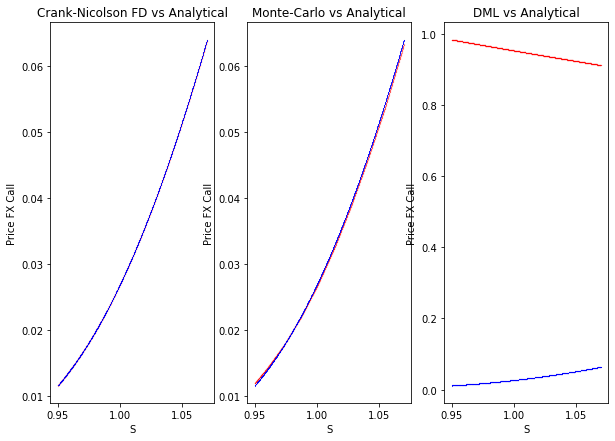

In [123]:
fig = plt.figure(figsize = (10,7))
X = spot_charts
Z1 = call_fx_cn
Z2 = call_fx_mc
Z3 = call_fx_dml
Z4 = call_fx_analytical

ax1 = fig.add_subplot(131)
for c,m, Z in [('r','o', Z1), ('b','^', Z4)]:
    ax1.scatter(X, Z, c = c,marker = m,s=0.02)

ax1.set_xlabel('S')
ax1.set_ylabel('Price FX Call')
ax1.title.set_text('Crank-Nicolson FD vs Analytical')

ax2 = fig.add_subplot(132)
for c, m, Z in [('r','o', Z2), ('b','^', Z4)]:
    ax2.scatter(X, Z, c = c, marker = m,s=0.02)

ax2.set_xlabel('S')
ax2.set_ylabel('Price FX Call')
ax2.title.set_text('Monte-Carlo vs Analytical')

ax3 = fig.add_subplot(133)
for c, m, Z in [('r','o', Z3), ('b','^', Z4)]:
    ax3.scatter(X, Z, c = c, marker = m,s=0.02)

ax3.set_xlabel('S')
ax3.set_ylabel('Price FX Call')
ax3.title.set_text('DML vs Analytical')

plt.show()

In [124]:
def calc_rmse(exact,est):
    rmse=np.sqrt(((exact-est)**2).mean(axis=0))
    return rmse

In [125]:
def survival_func(t,l=1.4,p=4):
    F=np.exp(-(l*t)**p)
    return F
    
    
def default_func(t,l=0.5):
    f=l*np.exp(-l*t)
    return f

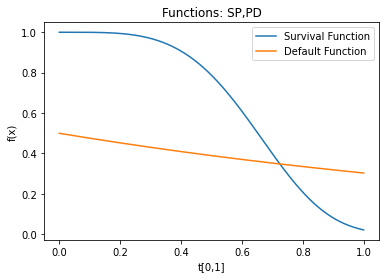

In [126]:
# define a range of x values
x_axis = np.arange(0, 1, 0.001)

# create lists of values
survival_vals = [survival_func(x) for x in x_axis]
default_vals = [default_func(x) for x in x_axis]

# plot the result 
plt.figure()
plt.plot(x_axis, survival_vals,label='Survival Function')
plt.plot(x_axis, default_vals,label='Default Function')
plt.xlabel('t[0,1]')
plt.ylabel('f(x)')
plt.title('Functions: SP,PD')
plt.legend()
plt.show()

In [128]:
from scipy import integrate

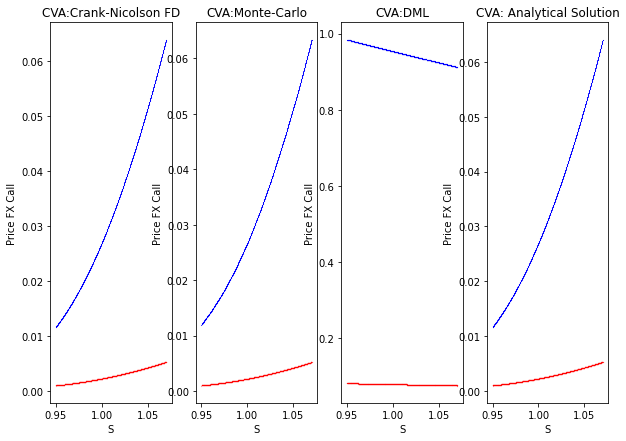

In [129]:
recovery_rate=0.7
maturity=1.0
integral=integrate.quad(lambda x:survival_func(x)*default_func(x),0,maturity)[0]

fig = plt.figure(figsize = (10,7))
X = spot_charts
Z1_cva = (1-recovery_rate)*call_fx_cn*integral
Z2_cva = (1-recovery_rate)*call_fx_mc*integral
Z3_cva = (1-recovery_rate)*call_fx_dml*integral
Z4_cva = (1-recovery_rate)*call_fx_analytical*integral

ax1 = fig.add_subplot(141)
for c,m, Z in [('r','o', Z1_cva), ('b','^', Z1)]:
    ax1.scatter(X, Z, c = c,marker = m,s=0.02)

ax1.set_xlabel('S')
ax1.set_ylabel('Price FX Call')
ax1.title.set_text('CVA:Crank-Nicolson FD')

ax2 = fig.add_subplot(142)
for c, m, Z in [('r','o', Z2_cva), ('b','^', Z2)]:
    ax2.scatter(X, Z, c = c, marker = m,s=0.02)

ax2.set_xlabel('S')
ax2.set_ylabel('Price FX Call')
ax2.title.set_text('CVA:Monte-Carlo')

ax3 = fig.add_subplot(143)
for c, m, Z in [('r','o', Z3_cva), ('b','^', Z3)]:
    ax3.scatter(X, Z, c = c, marker = m,s=0.02)

ax3.set_xlabel('S')
ax3.set_ylabel('Price FX Call')
ax3.title.set_text('CVA:DML')

ax4 = fig.add_subplot(144)
for c, m, Z in [('r','o', Z4_cva), ('b','^', Z4)]:
    ax4.scatter(X, Z, c = c, marker = m,s=0.02)

ax4.set_xlabel('S')
ax4.set_ylabel('Price FX Call')
ax4.title.set_text('CVA: Analytical Solution')

plt.show()